In [97]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor
from scipy.stats import spearmanr

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE


In [98]:
transcripts = {
    "HEART": {
        "male": [],
        "female": []
    }, 
    "BRAIN0": {
        "male": [],
        "female": []
    }, 
    "BRAIN1": {
        "male": [],
        "female": []
    }, 
}

In [99]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
# organ = "BRAIN1"
# 
sex = 'male'
sex = 'female'

n_opt_features = {
    "HEART": {
        "male": 9,
        "female": 11
    }, 
    "BRAIN0": {
        "male": 7,
        "female": 7
    }, 
    "BRAIN1": {
        "male": 17,
        "female": 8
    }, 
}

# transcripts[organ] = {}
# transcripts[organ][sex] = []


In [100]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/HEART.preprocessed.h5')

In [101]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]
# data
if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 




data_male = data.loc[data_header['sex'] == "male"]
data_female = data.loc[data_header['sex'] == "female"]

data_header_male = data_header.loc[data_header['sex'] == "male"]
data_header_female = data_header.loc[data_header['sex'] == "female"]

# fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
# sns.regplot(y=data[data.columns[0]], x=data_header['Age'], ax=axs[0], label='male+female')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
#             label='male')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
#             label='female')
# axs[0].legend()
# axs[1].legend()

data_both = data.copy(deep=True)
data_header_both = data_header.copy(deep=True)

data = data.loc[data_header['sex'] == sex]
data_header = data_header.loc[data_header['sex'] == sex]



In [102]:
rhos_male = []
pvalues_male = []
rhos_female = []
pvalues_female = []

for i in tqdm(range(data_male.values.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(data_male.values[:, i], data_header_male['Age'].values)
    rhos_male.append(rho)
    pvalues_male.append(pvalue)
    
for i in tqdm(range(data_female.values.shape[1])):
    rho, pvalue = spearmanr(data_female.values[:, i], data_header_female['Age'].values)
    rhos_female.append(rho)
    pvalues_female.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
rhos_male = np.array(rhos_male)
rhos_female = np.array(rhos_female)

100%|██████████| 1608/1608 [00:00<00:00, 1610.37it/s]


1.4450364680145382
0.00578968263361744
0.043364159495627816


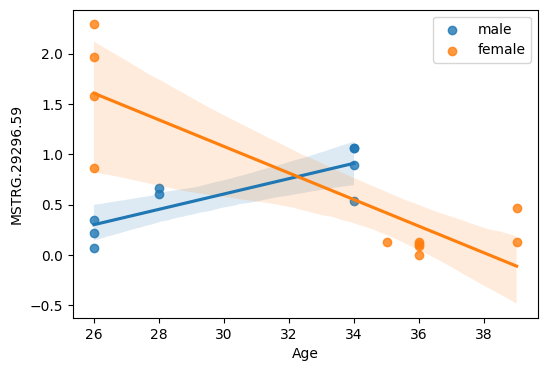

In [103]:
# rhos_male_sign = rhos_male > 0
# rhos_female_sign = rhos_female > 0

# diff_corr_ids = np.where(np.logical_xor(rhos_male_sign, rhos_female_sign))
# diff_corr_ids_sorted = np.argsort(np.abs(rhos_female[diff_corr_ids]))[::-1]

diff_corr_ids_sorted = np.argsort((rhos_male - rhos_female)**2)[::-1]


index = 2
print((rhos_male - rhos_female)[diff_corr_ids_sorted[index]])

print(pvalues_male[diff_corr_ids_sorted[index]])
print(pvalues_female[diff_corr_ids_sorted[index]])


fig, axs = plt.subplots(figsize=(6, 4))
# sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data_male[data_male.columns[diff_corr_ids_sorted[index]]], x=data_header_male['Age'], ax=axs, label='male')
sns.regplot(y=data_female[data_female.columns[diff_corr_ids_sorted[index]]], x=data_header_female['Age'], ax=axs, label='female')
axs.legend()


In [104]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'
eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [105]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000217939.7,ENST00000219919.9,ENST00000225328.10,ENST00000229270.8,ENST00000229384.5,ENST00000254090.9,ENST00000257359.7,ENST00000258646.3,ENST00000262483.13,ENST00000262816.11,...,MSTRG.8936.21,MSTRG.8962.2,MSTRG.8982.1,MSTRG.9001.7,MSTRG.9028.1,MSTRG.9324.5,MSTRG.9679.13,MSTRG.9771.2,MSTRG.9909.7,MSTRG.9947.1
SRR21423854,0.692847,0.169015,0.103467,0.620529,0.449301,0.652492,0.235829,0.039518,0.366129,1.098372,...,0.147480,1.418520,0.162945,0.317387,1.005056,0.283620,0.060140,0.077940,0.024850,0.653897
SRR21423855,1.053730,0.059224,0.089468,4.005813,0.405313,0.625610,0.877665,0.402099,0.088854,0.000000,...,0.203507,0.434382,0.011706,0.052873,0.401192,1.038025,0.024541,0.218144,0.187792,0.163202
SRR21423856,1.491178,0.267613,0.637205,0.181627,0.099189,0.871467,5.377368,0.586346,1.281584,0.178462,...,0.000000,0.105388,1.639669,0.104783,3.336985,0.496097,0.043006,0.271772,0.109342,1.887951
SRR21423857,2.628394,0.000000,0.815320,1.188072,1.366309,1.080534,3.654236,0.000385,1.188402,0.014098,...,0.255793,0.000000,1.595902,0.135547,0.648711,0.118269,0.023836,0.251996,2.661734,0.097166
SRR21423858,0.278420,0.225846,0.000000,4.960088,0.101330,0.928433,0.452067,1.851591,0.799651,0.505292,...,0.310206,2.727918,0.500730,0.101400,0.494459,0.000000,0.032660,0.444726,0.024961,0.827599
SRR21423859,0.653704,0.243602,0.476835,2.007073,0.162691,0.160169,0.815197,0.001605,0.237197,0.076539,...,0.089988,0.244740,0.512401,0.080516,0.291404,0.627915,0.006473,0.233410,0.515850,0.405636
SRR21423860,1.343977,2.378827,0.621828,3.847074,0.099150,0.289817,3.341295,0.651025,1.351555,0.093154,...,0.284223,0.026528,0.306837,0.270726,0.490611,0.048169,0.033190,0.895118,0.010526,0.272126
SRR21423861,0.267426,0.048613,0.432605,7.518103,0.476492,0.702371,0.417664,0.621421,0.217686,0.059208,...,0.252011,2.418016,0.849561,0.069026,0.366430,1.194101,0.012952,0.261506,0.799191,0.136523
SRR21423862,0.081404,0.077477,0.163545,0.371893,0.099220,0.397364,0.330789,0.000428,0.081949,0.339403,...,2.119527,1.966165,0.075975,0.052836,1.595356,0.333593,0.032624,0.116160,0.611691,3.317049
SRR21423863,0.809748,0.432016,0.127370,0.927013,0.096971,0.527667,0.509695,0.000324,1.482051,0.310217,...,0.115153,0.554210,0.920425,0.053505,0.604436,1.106647,3.412208,0.000000,0.066912,0.491464


In [106]:
rhos = []
pvalues = []

# y = data_header[value_to_predict]
# X = data.values

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values


for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)


100%|██████████| 1608/1608 [00:01<00:00, 1589.15it/s]


In [107]:
# np.argwhere(np.array(pvalues) < 0.05).shape
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)
# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


In [108]:
# Select by correlation value

# corr_threshold = 0.96
# corr_threshold = 0.5
# corr_threshold = 0.1

# if np.abs(rhos).max() > corr_threshold:
#     sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
#     sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
#     # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
# else:
#     sorted_corr_ids = []

In [109]:
# select by feature importance
model = XGBRegressor(n_estimators=300, max_depth=4, )

X = data.values
y = data_header['Age'].loc[data_header['sex'] == sex].values

# model.fit(RobustScaler().fit_transform(X),  y)
model.fit(X,  y)
importances = model.feature_importances_

sorted_corr_ids = np.argsort(importances).ravel()[::-1][:50]

In [110]:
# select by by variance

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")

gtf_data

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
ENST00000217939.7,chrX,HAVANA,transcript,3308565,3346652,NaN,-,0,ENSG00000101825.8,,MXRA5,ENSG00000101825.8,ENST00000217939.7
ENST00000219919.9,chr15,StringTie,transcript,58138381,58186052,1000.0,+,0,MSTRG.11550,,AQP9,ENSG00000103569.11,ENST00000219919.9
ENST00000225328.10,chr17,StringTie,transcript,3673227,3696654,1000.0,-,0,MSTRG.14143,,P2RX5,ENSG00000083454.23,ENST00000225328.10
ENST00000229270.8,chr12,StringTie,transcript,6867119,6870948,1000.0,+,0,MSTRG.7199,,TPI1,ENSG00000111669.15,ENST00000229270.8
ENST00000229384.5,chr12,StringTie,transcript,120446577,120460883,1000.0,+,0,MSTRG.8713,,GATC,ENSG00000257218.6,ENST00000229384.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSTRG.9324.5,chr13,StringTie,transcript,49912898,49936490,1000.0,-,0,MSTRG.9324,,,,MSTRG.9324.5
MSTRG.9679.13,chr13,StringTie,transcript,113232619,113267144,1000.0,+,0,MSTRG.9679,,,,MSTRG.9679.13
MSTRG.9771.2,chr14,StringTie,transcript,20989802,20997035,1000.0,+,0,MSTRG.9771,,,,MSTRG.9771.2
MSTRG.9909.7,chr14,StringTie,transcript,24146740,24160660,1000.0,+,0,MSTRG.9909,,,,MSTRG.9909.7


In [111]:
import anndata as ad
import scanpy as sc

adata = ad.AnnData(data)
adata.var = gtf_data
adata.obs = data_header



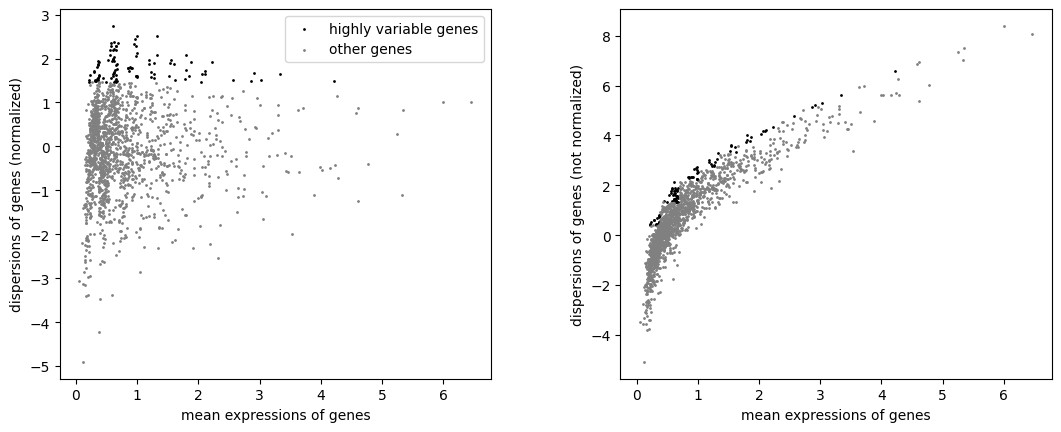

In [132]:
sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor='seurat')
sc.pl.highly_variable_genes(adata)


In [133]:
corr_ids = np.argwhere(adata.var['highly_variable']).ravel()
# corr_ids

sorted_corr_ids = corr_ids[np.argsort(adata[:, corr_ids].var['highly_variable_rank'].values)[::-1]]

adata[:, sorted_corr_ids].var

,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id,highly_variable,highly_variable_rank,means,variances,variances_norm,dispersions,dispersions_norm
ENST00000479108.5,chr1,StringTie,transcript,1301856,1307930,1000.0,-,0,MSTRG.211,,ACAP3,ENSG00000131584.19,ENST00000479108.5,True,NaN,0.336822,0.156690,1.703834,0.465537,1.535161
ENST00000483435.5,chr1,StringTie,transcript,29193817,29200589,1000.0,-,0,MSTRG.822,,MECR,ENSG00000116353.16,ENST00000483435.5,True,NaN,0.901726,0.556549,1.369243,2.342678,1.790486
ENST00000486711.1,chr3,StringTie,transcript,160430929,160432515,1000.0,+,0,MSTRG.25142,,SMC4,ENSG00000113810.16,ENST00000486711.1,True,NaN,0.364878,0.172093,1.326442,0.822889,1.949919
ENST00000515794.3,chr6,StringTie,transcript,167826893,167972120,1000.0,+,0,MSTRG.30737,,AFDN,ENSG00000130396.22,ENST00000515794.3,True,NaN,0.941856,0.683022,1.555240,2.637867,2.326138
ENST00000521603.5,chr8,StringTie,transcript,90001458,90037021,1000.0,+,0,MSTRG.33383,,DECR1,ENSG00000104325.7,ENST00000521603.5,True,NaN,0.607128,0.362259,1.335775,1.775184,2.188774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000471741.1,chr10,StringTie,transcript,99420267,99430661,1000.0,-,0,MSTRG.4814,,GOT1,ENSG00000120053.12,ENST00000471741.1,True,42.0,0.361625,0.178986,1.932172,0.476373,1.547738
ENST00000474665.1,chr3,StringTie,transcript,45665675,45674624,1000.0,+,0,MSTRG.23950,,LIMD1,ENSG00000144791.10,ENST00000474665.1,True,30.0,0.648141,0.438181,2.068620,1.419059,1.626204
ENST00000520216.5,chr5,StringTie,transcript,119493818,119502092,1000.0,+,0,MSTRG.28071,,HSD17B4,ENSG00000133835.18,ENST00000520216.5,True,29.0,1.619935,1.360204,2.076737,3.354679,1.515717
MSTRG.3623.2,chr1,StringTie,transcript,246724388,246768278,1000.0,+,0,MSTRG.3623,,,,MSTRG.3623.2,True,21.0,0.648502,0.454503,2.218859,1.358004,1.529757


In [134]:
data.columns[sorted_corr_ids]

Index(['ENST00000479108.5', 'ENST00000483435.5', 'ENST00000486711.1',
       'ENST00000515794.3', 'ENST00000521603.5', 'ENST00000530674.1',
       'ENST00000533595.5', 'ENST00000537531.2', 'ENST00000550479.1',
       'ENST00000556216.5', 'ENST00000595368.5', 'ENST00000569720.2',
       'ENST00000570801.1', 'ENST00000587345.1', 'ENST00000588861.1',
       'ENST00000590275.1', 'ENST00000591341.1', 'ENST00000591946.5',
       'ENST00000593064.5', 'ENST00000593609.1', 'ENST00000594361.1',
       'ENST00000566589.1', 'ENST00000320683.7', 'ENST00000340855.11',
       'ENST00000343388.11', 'ENST00000370094.7', 'ENST00000389154.7',
       'ENST00000398129.5', 'ENST00000408912.7', 'ENST00000426229.1',
       'ENST00000426907.5', 'ENST00000428458.1', 'ENST00000478800.1',
       'ENST00000451619.1', 'ENST00000459880.1', 'ENST00000460428.5',
       'ENST00000462777.1', 'ENST00000466976.1', 'ENST00000470431.5',
       'ENST00000471657.1', 'ENST00000472019.5', 'ENST00000473593.1',
       'ENST000004

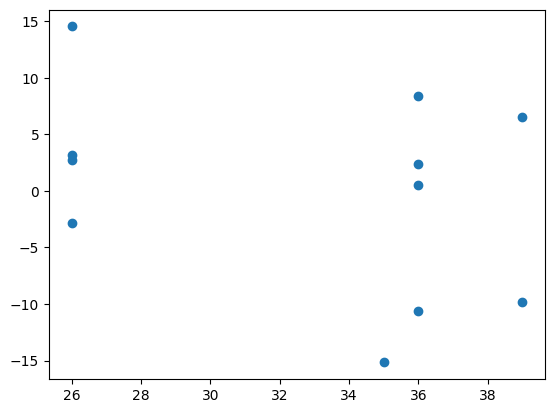

In [135]:
# # plt.figure(figsize=(16,6))
# sns.scatterplot(
#     y=np.abs(rhos[sorted_corr_ids]), 
#     x=data.columns[sorted_corr_ids],
#     )
# plt.xticks(rotation=90)


# X = data[data.columns[sorted_corr_ids[:n_features]]].values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

from sklearn.decomposition import PCA

pca = PCA(None)
X_trainsformed = pca.fit_transform(data_female)
# plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
# plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
plt.plot(data_header_female['Age'], X_trainsformed[:,3], 'o')
# plt.plot(data_header_both['Age'], X_trainsformed[:,0], 'o')

In [143]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['ENST00000479108.5', 'ENST00000483435.5', 'ENST00000486711.1',
        'ENST00000515794.3', 'ENST00000521603.5', 'ENST00000530674.1',
        'ENST00000533595.5', 'ENST00000537531.2', 'ENST00000550479.1',
        'ENST00000556216.5', 'ENST00000595368.5', 'ENST00000569720.2',
        'ENST00000570801.1', 'ENST00000587345.1', 'ENST00000588861.1',
        'ENST00000590275.1', 'ENST00000591341.1', 'ENST00000591946.5',
        'ENST00000593064.5', 'ENST00000593609.1', 'ENST00000594361.1',
        'ENST00000566589.1', 'ENST00000320683.7', 'ENST00000340855.11',
        'ENST00000343388.11', 'ENST00000370094.7', 'ENST00000389154.7',
        'ENST00000398129.5', 'ENST00000408912.7', 'ENST00000426229.1',
        'ENST00000426907.5', 'ENST00000428458.1', 'ENST00000478800.1',
        'ENST00000451619.1', 'ENST00000459880.1', 'ENST00000460428.5',
        'ENST00000462777.1', 'ENST00000466976.1', 'ENST00000470431.5',
        'ENST00000471657.1', 'ENST00000472019.5', 'ENST00000473593.1',
    

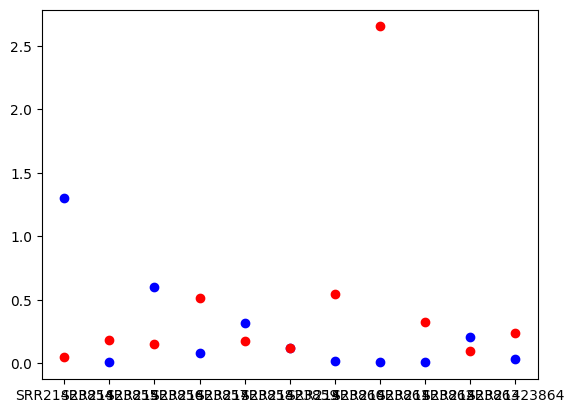

In [144]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [145]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR21423854    1.306327
SRR21423855    0.008328
SRR21423856    0.600082
SRR21423857    0.079443
SRR21423858    0.317652
SRR21423859    0.118830
SRR21423860    0.021359
SRR21423861    0.006255
SRR21423862    0.008437
SRR21423863    0.207549
SRR21423864    0.031907
Name: ENST00000479108.5, dtype: float32

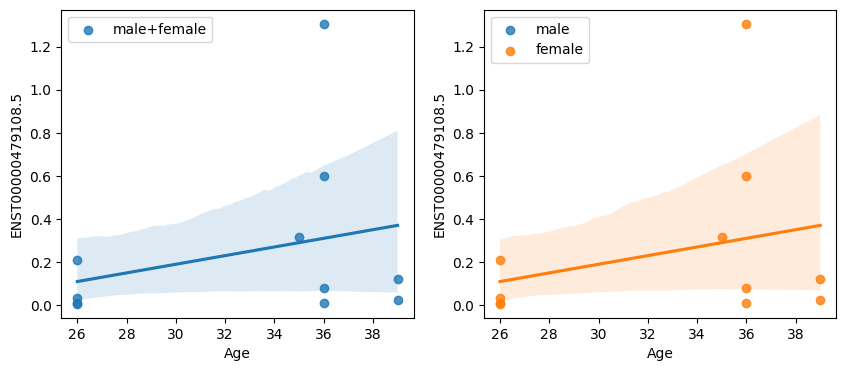

In [146]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [148]:


# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [5]:

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    y = data_header['Age'].loc[data_header['sex'] == sex].values

    # print(X.shape)
    print(f"{n_features=}")
    
    # cv = StratifiedKFold(n_splits=5)
    cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values


        model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor(n_estimators=300, max_depth=4, )
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)

        preds.append(pred)
        vals.append(y_val)
                
        # X_train_ = sm.add_constant(X_train_)
        # X_test = sm.add_constant(X_test, has_constant='add')
        
        # mod = sm.GLS(y_train_, X_train_).fit()
        # gls_pred = mod.predict(X_test)
        # gls_preds.append(gls_pred)
        
        # rmses.append(
        #     RMSE(pred, y_val)
        # )
        # r2s.append(
        #     r2_score(y_val, pred)
        # )

    print("RMSE: ", RMSE(preds, vals))
    # print("RMSE: ", RMSE(gls_preds, vals))
    print("R2: ", r2_score(vals, preds))
    # print("R2: ", r2_score(vals, gls_preds))
    
    # print("RMSE: ", np.mean(rmses))
    # print("R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

11
n_features=1


11it [00:00, 2048.64it/s]


RMSE:  6.2488284536532515
R2:  -0.3962147465205572
--------------------
n_features=2


11it [00:00, 2377.36it/s]


RMSE:  6.339662920431681
R2:  -0.43710119364901256
--------------------
n_features=3


11it [00:00, 2346.28it/s]


RMSE:  6.297245075322837
R2:  -0.4179346218026019
--------------------
n_features=4


11it [00:00, 1987.99it/s]


RMSE:  6.327574254898136
R2:  -0.4316258008573328
--------------------
n_features=5


11it [00:00, 2273.67it/s]


RMSE:  6.355491084593159
R2:  -0.44428614009678435
--------------------
n_features=6


11it [00:00, 2255.77it/s]


RMSE:  6.2011485162334825
R2:  -0.37498918243692425
--------------------
n_features=7


11it [00:00, 2645.03it/s]


RMSE:  6.365090742195494
R2:  -0.44865248195103935
--------------------
n_features=8


11it [00:00, 2391.28it/s]


RMSE:  5.271600100854405
R2:  0.006335141128041122
--------------------
n_features=9


11it [00:00, 2475.45it/s]


RMSE:  5.347674401543825
R2:  -0.022550887144261234
--------------------
n_features=10


11it [00:00, 2360.09it/s]


RMSE:  5.278597504857508
R2:  0.003695453365000656
--------------------
n_features=11


11it [00:00, 2459.35it/s]

RMSE:  5.347862563957085
R2:  -0.02262284703304096
--------------------


array([[ 0.11011602, -1.91549173, -1.38775379,  0.10945374,  0.63817189,
        -0.2234067 , -1.24019565, -1.6175502 ,  0.47417732,  0.63075678,
         0.89587376]])

11
n_features=2


11it [00:00, 2016.14it/s]

RMSE:  3.9495994773460636
MAE:  2.698632113037776
R2:  0.44222232275244444


array([[ 1.45190967, -4.09607343]])

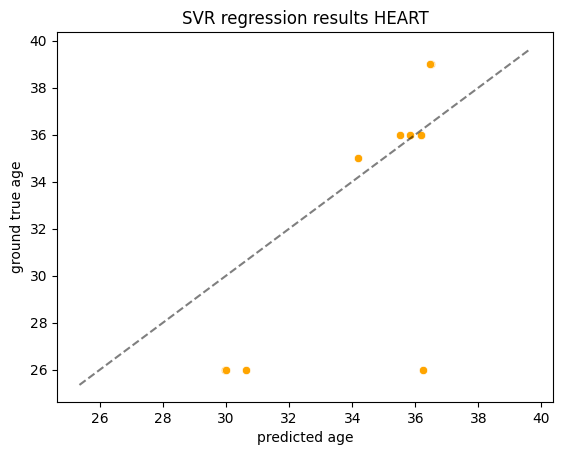

In [130]:


# n_features = 5
# n_features = -1

# sex = 'male'
print(data.shape[0])

# n_features = n_opt_features[organ][sex]
n_features = 2

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

# print(X.shape)
print(f"{n_features=}")

# cv = StratifiedKFold(n_splits=5)
cv = LeaveOneOut()

preds = []
vals  = []
gls_preds = []

rmses = []
maes = []
r2s = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    # train_scaler = RobustScaler().fit(X_train)
    # test_scaler = RobustScaler().fit(X_test)
    # X_train = train_scaler.transform(X_train)
    # X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    
    X_val = X_test
    y_val = y_test
    
    model = svm.SVR(kernel='linear')
    # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
    # model = LinearRegression()
    # model = Ridge()
    # model = XGBRegressor(n_estimators=300, max_depth=4, )
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    
    model.fit(X_train_, y_train_)
    pred = model.predict(X_val)
    
    preds.append(pred)
    vals.append(y_val)

print("RMSE: ", RMSE(preds, vals))
# print("RMSE: ", RMSE(gls_preds, vals))
print("MAE: ", MAE(preds, vals))
print("R2: ", r2_score(vals, preds))

# model.coef_

colors = {
    'male': 'blue',
    "female": "orange"
}

g = sns.scatterplot(x=np.array(preds).ravel(), y=np.array(vals).ravel(), color=colors[sex])
g.set_title(f"SVR regression results {organ}")
g.set_xlabel("predicted age")
g.set_ylabel("ground true age")

lims = [
    np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
    np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
]


g.plot(lims, lims, '--', color='k', alpha=0.5)

# g.set_xlim(lims)
# g.set_ylim(lims)

transcripts[organ][sex] = data.columns[sorted_corr_ids[:n_features]].tolist()
model.coef_


(array([ 9.,  5.,  3.,  0., 12.,  9.,  9.,  6.,  6.,  6.]),
 array([21. , 24.7, 28.4, 32.1, 35.8, 39.5, 43.2, 46.9, 50.6, 54.3, 58. ]),
 <BarContainer object of 10 artists>)

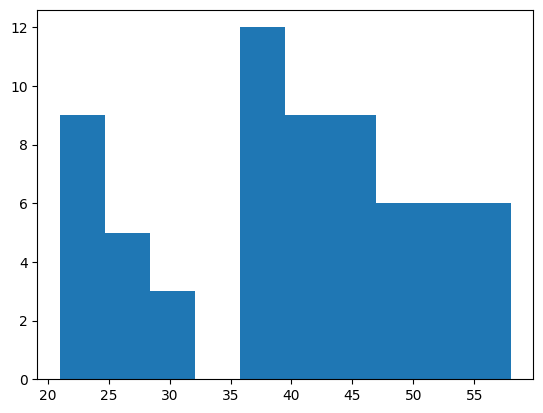

In [26]:
plt.hist(np.array(vals).ravel())

In [60]:
# import copy
# transcripts_dict = copy.deepcopy(transcripts)

# # for organ in ['BRAIN0', "HEART", "BRAIN1"]:
# #     for sex in ['female', 'male']:
# #         transcripts_dict[organ][sex] = [".".join(el.split(".")[:-1]) for el in transcripts_dict[organ][sex]]
# transcripts_dict


In [488]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

Chromosomes:  female
['HEART'] : 
{'ENST00000687101.1', 'ENST00000519878.1', 'MSTRG.23364.2', 'ENST00000372841.8', 'ENST00000417040.1', 'ENST00000590632.1', 'ENST00000473301.1', 'ENST00000511757.1', 'ENST00000524627.5', 'ENST00000565500.5', 'ENST00000554243.1', 'MSTRG.27522.8', 'ENST00000366529.4', 'ENST00000466186.2', 'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000580063.1', 'ENST00000420515.1', 'MSTRG.11225.100', 'ENST00000556476.1'}
['BRAIN1'] : 
{'MSTRG.21417.7', 'MSTRG.30797.34', 'ENST00000519615.1', 'ENST00000689865.2', 'ENST00000437783.1', 'ENST00000569155.1', 'ENST00000409718.5', 'MSTRG.29364.2', 'ENST00000525549.5', 'MSTRG.17547.1', 'ENST00000543693.5', 'ENST00000656109.1', 'MSTRG.24372.1', 'ENST00000636170.1', 'ENST00000391138.1', 'ENST00000368732.5', 'MSTRG.31018.1', 'ENST00000414562.1', 'ENST00000336169.3', 'ENST00000675702.1', 'MSTRG.27407.13', 'ENST00000443037.1', 'ENST00000360415.7', 'ENST00000562938.6', 'ENST00000675559.1'}
['BRAIN0'] : 
{'ENST00000703798.1', 'MSTRG.4

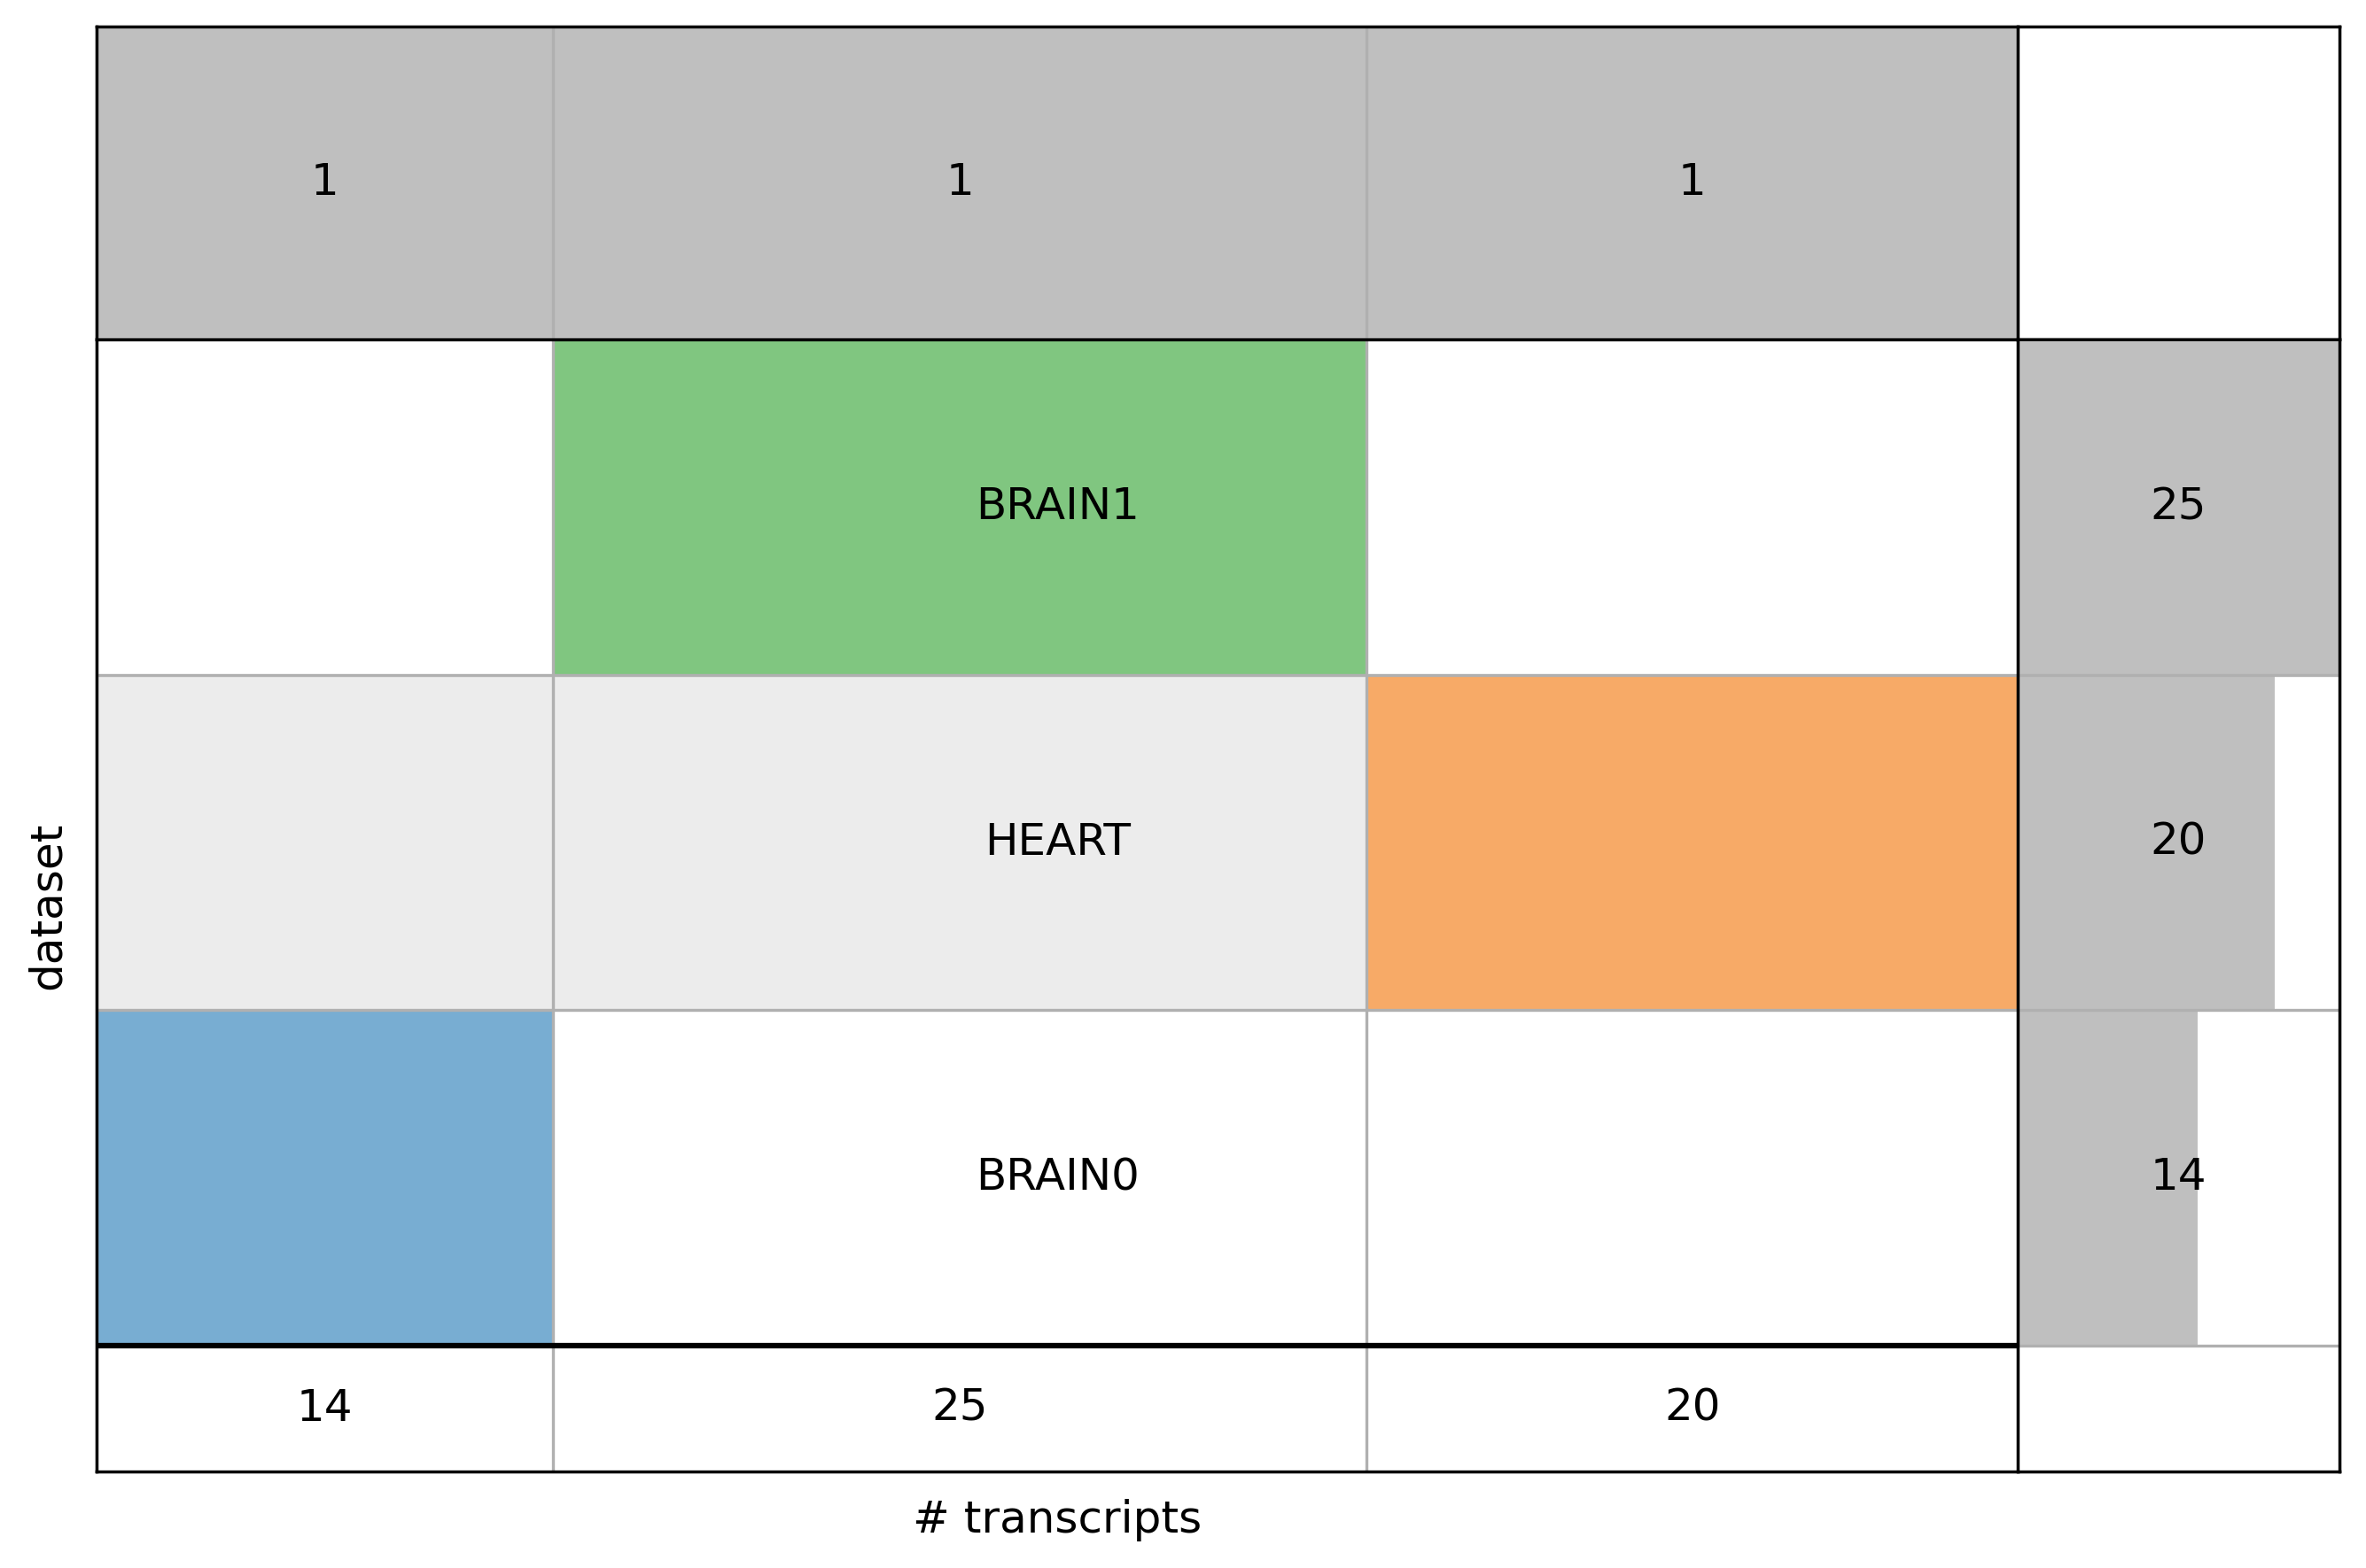

In [492]:

sex = ['male', 'female'][1]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1"]:
    # test_dict[organ] = set(transcripts_dict[organ][sex])
    test_dict[organ] = set(transcripts_dict[organ]['male']).union(set(transcripts_dict[organ]['female']))


plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('dataset')


print("Chromosomes: ", sex)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])


Organ:  HEART
['male'] : 
{'ENST00000687101.1', 'ENST00000417040.1', 'ENST00000565500.5', 'ENST00000590632.1', 'ENST00000580063.1', 'MSTRG.23364.2', 'ENST00000473301.1', 'ENST00000511757.1', 'MSTRG.27522.8'}
['female'] : 
{'ENST00000466186.2', 'ENST00000519878.1', 'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000420515.1', 'MSTRG.11225.100', 'ENST00000554243.1', 'ENST00000524627.5', 'ENST00000366529.4', 'ENST00000556476.1', 'ENST00000372841.8'}


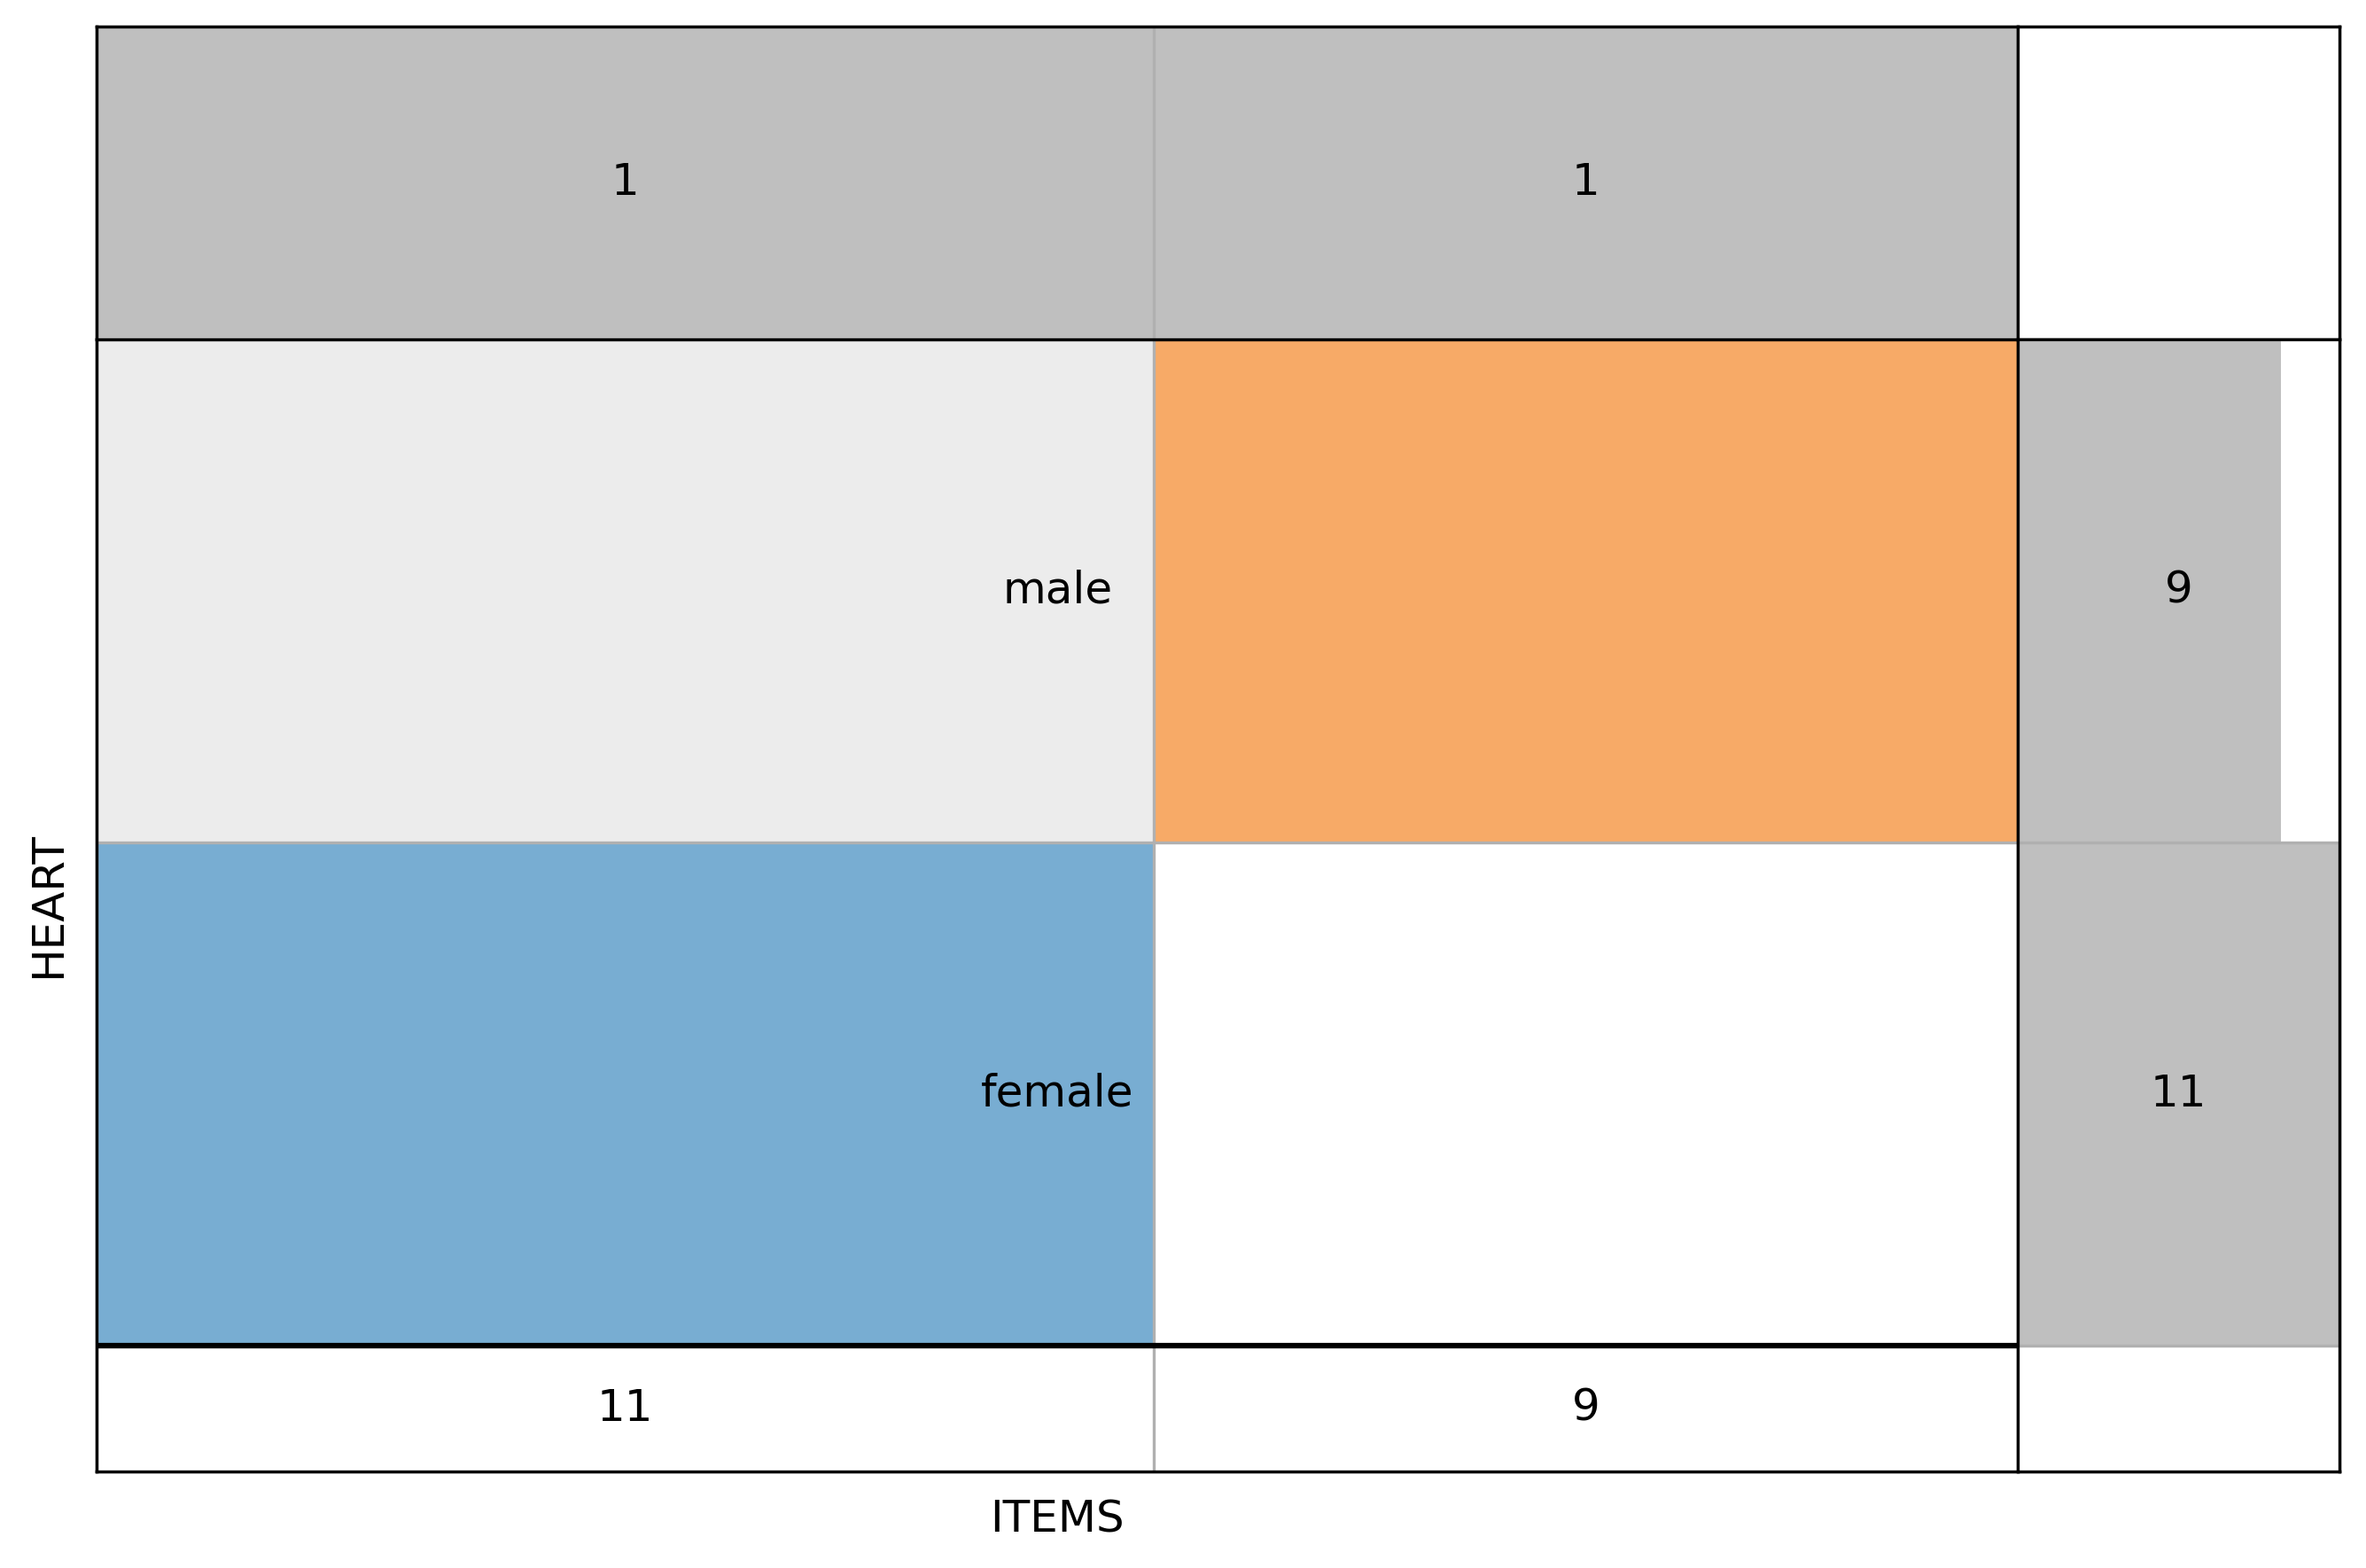

In [490]:
organ = ['BRAIN0', "HEART", "BRAIN1"][1]
test_dict = {}
for sex in ['male', 'female']:
    test_dict[sex] = set(transcripts_dict[organ][sex])

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

g.axes['main'].set_ylabel(organ)

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])


<Axes: >

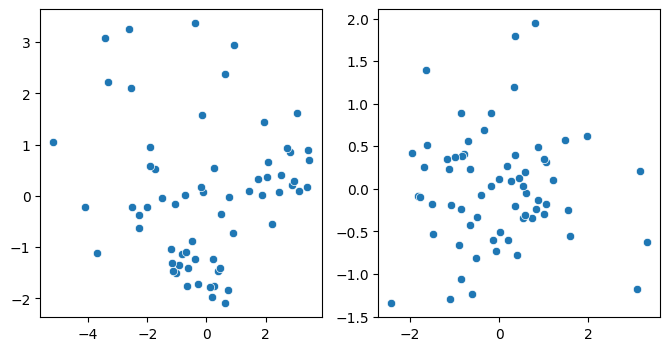

In [491]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

reducer = PCA(n_components=4)

X_transformed = reducer.fit_transform(X)

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], ax=axs[0])
sns.scatterplot(x=X_transformed[:, 2], y=X_transformed[:, 3], ax=axs[1])
# sns.scatterplot(x=X[:, 2], y=X[:, 3], ax=axs[1])
